# Coding Exercises Week 5: Unsupervised Learning

The task for this week is a little bit different. Using the code in the examples as a guide, do the following:

- Fit a kmeans, pca, and pca+kmeans model for a selection of the variables from the BES data.
- Visualise the clusterings.
- Interpret the principal components. To do this, you will need to inspect how each component "weights" each of the features. The higher the weight, the proportion of the variance of the component is being derived from this weight.
- Interpret the clusters: what kind of people are assigned to each cluster? Does this make sense? How does this match up to your understanding of the division within British society?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set_style('darkgrid')

In [2]:
link = 'http://github.com/muhark/dpir-intro-python/raw/master/Week2/data/bes_data_subset_week2.feather'
df = pd.read_feather(link)

features = ['region', 'Age', 'a02', 'a03', 'e01',
            'k01', 'k02', 'k11', 'k13', 'k06', 'k08',
            'y01', 'y03', 'y06', 'y08', 'y09', 'y11', 'y17']

col_name_dict =  {
    'a01': 'top_issue',
    'a02': 'top_issue-best_party',
    'a03': 'politics_interest',
    'e01': 'ideo_LR',
    'k01': 'politics_attention',
    'k02': 'read_pol_news',
    'k03': 'newspaper',
    'k11': 'canvasser_contact',
    'k13': 'party_contact',
    'k06': 'twitter_use',
    'k08': 'facebook_use',
    'y01': 'income_band',
    'y03': 'housing',
    'y06': 'religion',
    'y07': 'religiosity',
    'y08': 'union_member',
    'y09': 'gender',
    'y11': 'ethnicity',
    'y17': 'employment_type',
    'y18': 'has_worked'
}

df = df[features].dropna()
df = df.rename(col_name_dict, axis=1)
data = pd.get_dummies(df)

scaler = StandardScaler()
X_norm = scaler.fit_transform(data.values)

In [3]:
# Fitting k-means
kmeans = KMeans(n_clusters=5, random_state=634)
kmeans.fit(X_norm)

# Fitting PCA
pca = PCA(n_components=2, random_state=634)
pca = pca.fit(X_norm)
reduced_X = pca.fit_transform(X_norm)

# Combining
pcakmeans = KMeans(n_clusters=5, random_state=634)
pcakmeans.fit(reduced_X)

# Adding back to original data
df['kmeans'] = kmeans.labels_.astype(str)
df['pcakmeans'] = pcakmeans.labels_.astype(str)

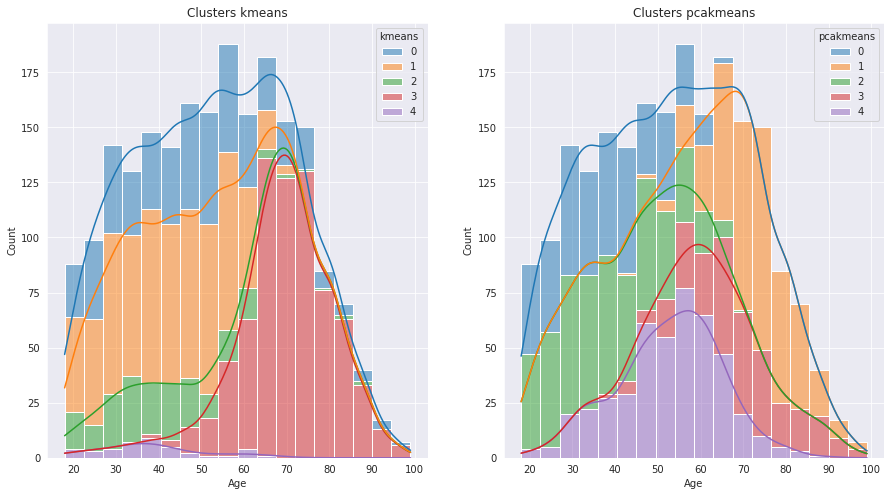

In [4]:
# Visualizing the Clusterings
# Visualizing age against clusterings

f, ax = plt.subplots(1, 2, figsize=(15, 8))
for i, clusters in enumerate(['kmeans', 'pcakmeans']):
    sns.histplot(df[[clusters, 'Age']].sort_values(clusters),
                 x= 'Age', ax=ax[i], kde=True, hue=clusters, multiple='stack')
    ax[i].set_title(f"Clusters {clusters}");

In [5]:
# Interpreting the principle components
comp_scores = pd.DataFrame(pca.components_, columns=data.columns).T
comp_scores.rename({0: 'PCA0', 1: 'PCA1'}, axis=1, inplace=True)

In [6]:
# The following table shows the features with the highest and lowest components weights.
# Remember that the components are orthogonal; they will be looking at different dimensions
# over which BES respondents differ.
# The first looks like it's picking up on a dimension where on one end, we have retired home owners
# who support the conservatives. So it's a sort of conservative/home-owner/holders of capital axis.
# The second looks like it's picking up on people who are not interested in the news or politics.
# So we have two main dimensions for BES data: political/social interest, and the axis that captures
# older conservative home owners.
# Note that this also says that the two dimensions are orthogonal: that means that there are
# respondents interested in news/politics regardless of where they fall on the first dimension,
# and that this interest differentiates them to the largest degree once we account for the first
# dimension.

pd.concat([
    pd.concat([comp_scores.nlargest(columns='PCA0', n=5)['PCA0'].reset_index(),
               comp_scores.nlargest(columns='PCA1', n=5)['PCA1'].reset_index()],
              axis=1),
    pd.concat([comp_scores.nsmallest(columns='PCA0', n=5)['PCA0'].reset_index(),
               comp_scores.nsmallest(columns='PCA1', n=5)['PCA1'].reset_index()],
              axis=1).iloc[::-1]
], axis=0).set_index(pd.Series(name='rank', data=np.hstack((np.arange(1, 6), np.arange(-5, 0)))))

,index,PCA0,index,PCA1
rank,,,,
1,Age,0.370229,read_pol_news_No,0.319246
2,employment_type_Retired from paid work,0.342792,politics_interest_Not at all interested,0.250764
3,housing_Own home outright,0.301215,politics_attention_0 Pay no attention,0.190091
4,facebook_use_No,0.267062,ideo_LR_Don`t know,0.177953
5,top_issue-best_party_Conservatives,0.211689,politics_interest_Not very interested,0.172314
-5,housing_Rented from private landlord,-0.138953,housing_Own home on mortgage,-0.158175
-4,housing_Own home on mortgage,-0.178711,twitter_use_Yes,-0.170510
-3,twitter_use_Yes,-0.199049,party_contact_Yes,-0.179493
-2,employment_type_Working full time - employee ...,-0.216530,politics_interest_Very interested,-0.202100


In [7]:
# Interpreting the clusters
from local_plot_utils import crosstab_heatmap
import warnings
warnings.filterwarnings('ignore')

df.loc[:, 'region'] = df['region'].str.replace(r"&", r"\&")

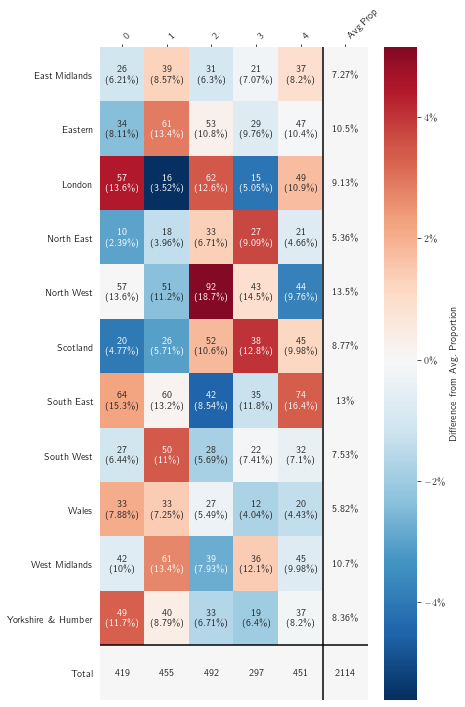

In [8]:
# The clusters don't appear to be strongly sorting on region.
# Strongest is maybe cluster 2 with NorthWest
f = crosstab_heatmap(df, 'pcakmeans', 'region')

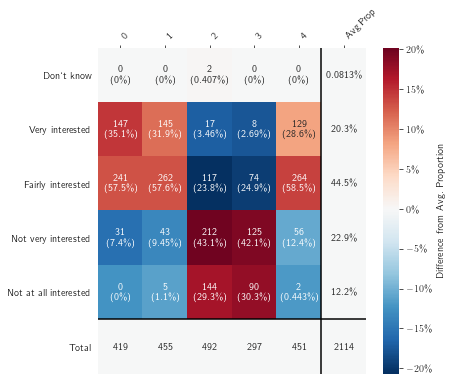

In [9]:
f = crosstab_heatmap(df, 'pcakmeans', 'politics_interest')

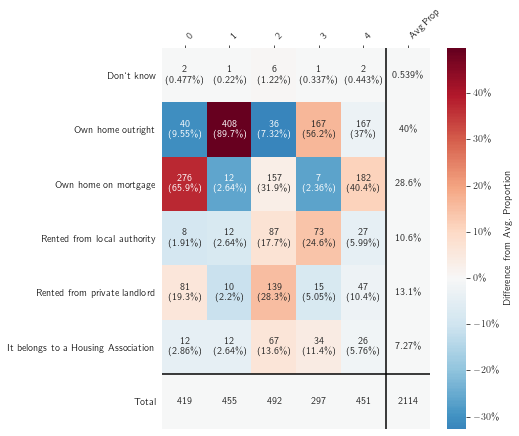

In [10]:
# Cluster 1 is home owners
# Clusters 0 and 2 are split opposite ways but both capture mortgage/private landlords
# Cluster 4 captures only mortgage
# Clusters 2 and 3 both capture rent from local authority/housing association
# Confusing is cluster 3: what group of people are split between home owners, local authority and HA?
f = crosstab_heatmap(df, 'pcakmeans', 'housing')

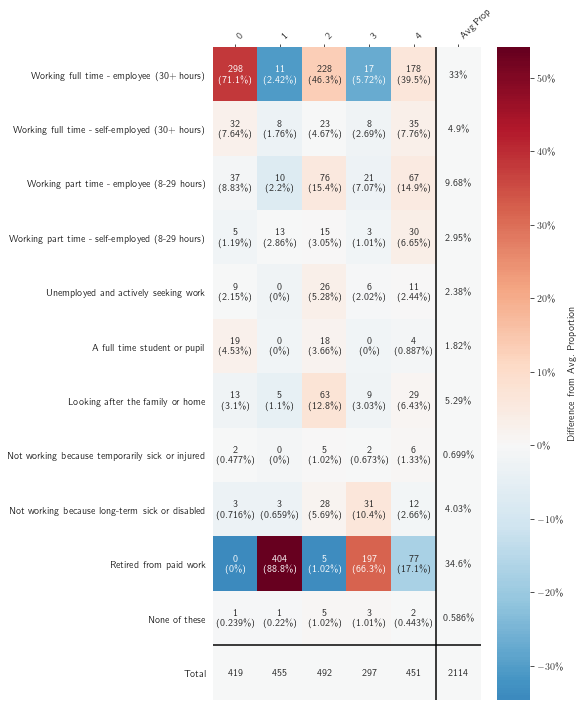

In [11]:
# Cluster 1 seems to be capturing retired home owners distributed across the country
# (except London)
f = crosstab_heatmap(df, 'pcakmeans', 'employment_type')

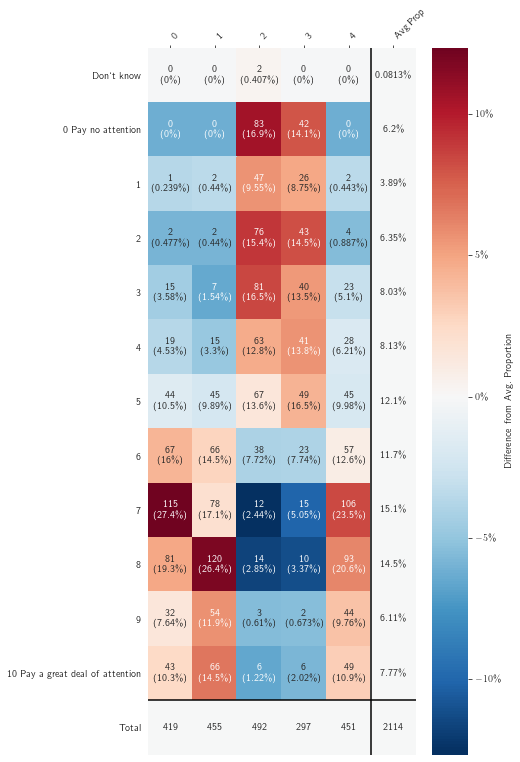

In [12]:
# 2 and 3 are less attention, 0 1 and 4 are more attention.
f = crosstab_heatmap(df, 'pcakmeans', 'politics_attention')

## Bonus Challenge

As mentioned, `sklearn.cluster` contains many other clustering algorithms. Read through the documentation at https://scikit-learn.org/stable/modules/clustering.html and choose one that you think you understand best (Agglomerative Clustering is the most intuitive, IMHO). Cluster the BES data with this algorithm, and compare results between the models.

In [17]:
# We can see how the clustering in the normed data relates to the reduced space
from sklearn.cluster import SpectralClustering, AgglomerativeClustering

In [ ]:
sc = SpectralClustering(n_clusters=5, random_state=634)
ac = AgglomerativeClustering(n_clusters=5)

sc.fit(X_norm)
ac.fit(X_norm)

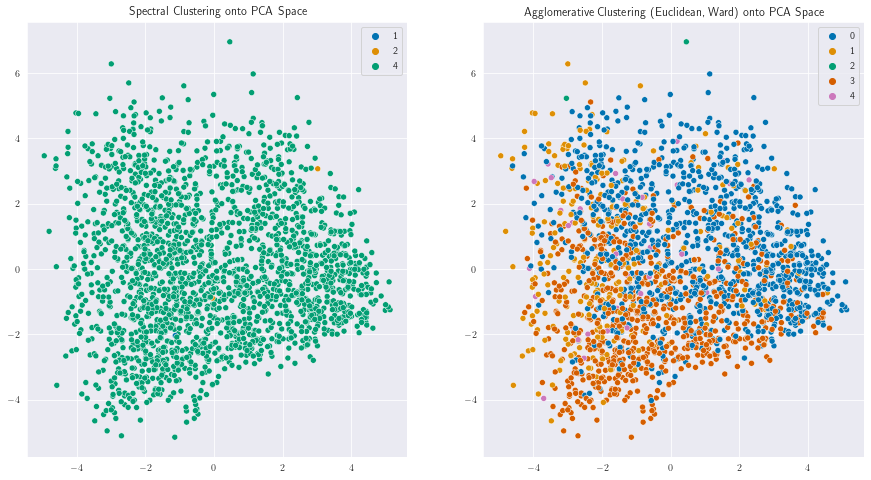

In [28]:
# Neither of these algorithms produced balanced classes
f, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1],
                hue=sc.labels_,
                palette=sns.color_palette(palette='colorblind', n_colors=3),
                ax=ax[0])
ax[0].set_title('Spectral Clustering onto PCA Space')
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1],
                hue=ac.labels_,
                palette=sns.color_palette(palette='colorblind', n_colors=5),
                ax=ax[1])
ax[1].set_title('Agglomerative Clustering (Euclidean, Ward) onto PCA Space');

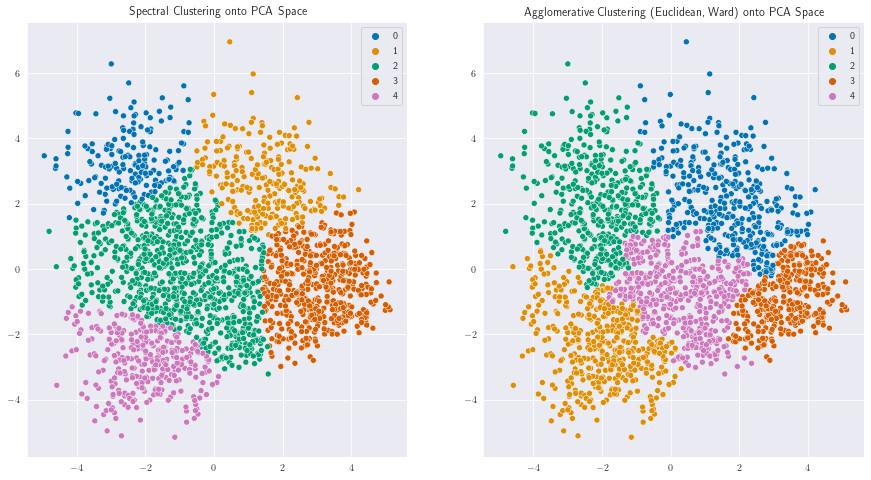

In [30]:
sc2 = SpectralClustering(n_clusters=5, random_state=634)
ac2 = AgglomerativeClustering(n_clusters=5)

sc2.fit(reduced_X)
ac2.fit(reduced_X)
f, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1],
                hue=sc2.labels_,
                palette=sns.color_palette(palette='colorblind', n_colors=5),
                ax=ax[0])
ax[0].set_title('Spectral Clustering onto PCA Space')
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1],
                hue=ac2.labels_,
                palette=sns.color_palette(palette='colorblind', n_colors=5),
                ax=ax[1])
ax[1].set_title('Agglomerative Clustering (Euclidean, Ward) onto PCA Space');